In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.precision", 3)

%matplotlib inline

In [7]:
DIR = "C://Users//Michael//Desktop//"

In [8]:
data = pd.read_json(DIR + "data_seminar_04.json", lines=True)
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2022-06-13 11:39:37.645,4013,18934,0.02,2.065e-04,NaN,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
1,next,2022-06-13 11:39:37.683,9693,29738,1.00,9.019e-04,3079.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
2,next,2022-06-13 11:39:37.692,9693,3079,0.06,9.229e-04,20078.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
3,next,2022-06-13 11:39:37.700,9693,20078,1.00,8.581e-04,12044.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
4,next,2022-06-13 11:39:37.708,9693,12044,0.00,9.272e-04,37424.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"


In [9]:
data.drop(columns = ['message', 'timestamp', 'experiments', 'recommendation'], inplace=True)

In [10]:
data['count'] = data.groupby(['user', 'track']).user.transform('size')
data = data.groupby(['track'],as_index=False).mean()
data.rename(columns={"time": "mean_time", "latency": "mean_latency"}, inplace=True)
data[['user', 'count']] = data[['user', 'count']].astype('int32')

In [11]:
data.head()

,track,user,mean_time,mean_latency,count
0,0,1625,1.000,7.937e-04,1
1,7,5026,0.346,8.096e-04,1
2,8,4984,0.377,8.434e-04,1
3,10,4500,0.449,8.800e-04,1
4,12,4840,0.426,8.535e-04,2


In [12]:
tracks = pd.read_json(DIR + "recsys-itmo-spring-2023/botify/data/tracks.json", lines=True)
tracks.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [13]:
data = data.merge(tracks, on='track', how='left')
data.head()

,track,user,mean_time,mean_latency,count,artist,title
0,0,1625,1.000,7.937e-04,1,Jack Johnson,The Cove
1,7,5026,0.346,8.096e-04,1,Kanye West,Stronger
2,8,4984,0.377,8.434e-04,1,Jack Johnson,Constellations
3,10,4500,0.449,8.800e-04,1,Foo Fighters,Learn To Fly
4,12,4840,0.426,8.535e-04,2,Lady GaGa,Paper Gangsta


In [14]:
data.shape

(19353, 7)

In [15]:
unique_users = data["user"].unique().shape[0]
unique_tracks = data["track"].unique().shape[0]
unique_artists = data["artist"].unique().shape[0]

print(f'Unique users: {unique_users}')
print(f'Unique tracks: {unique_tracks}')
print(f'Unique artists: {unique_artists}')

Unique users: 7062
Unique tracks: 19353
Unique artists: 5269


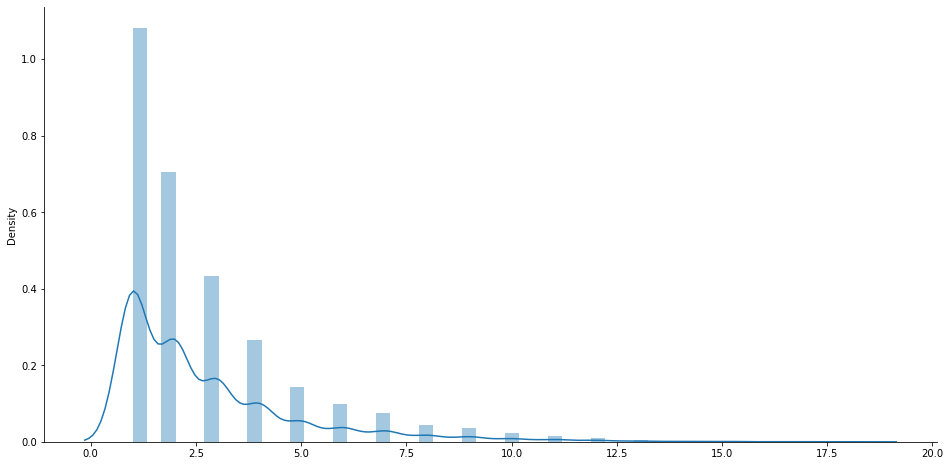

In [16]:
song_user = data.groupby('user')['track'].count()
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [17]:
print(f"A user listens to an average of {np.median(song_user)} songs, with minimum {np.min(song_user)} and maximum {np.max(song_user)} songs")

A user listens to an average of 2.0 songs, with minimum 1 and maximum 18 songs


In [18]:
df_songs_features = data.pivot(index='user', columns='track', values='count').fillna(0)

In [19]:
knn = NearestNeighbors(n_neighbors=50,metric='cosine')
Model = knn.fit(df_songs_features)

In [20]:
user = df_songs_features.iloc[1,]
distances, indices = Model.kneighbors([user])

neighbors=[]
for item in indices[0][1:]:
    neighbors.append(data[data.index == item].user.values[0])

neighbor_songs=pd.DataFrame(columns=data.columns)
for item in neighbors:
    neighbor_songs=neighbor_songs.append(data[data.user == item],ignore_index = True)
#neighbor_songs

In [21]:
neighbor_songs.sort_values(by=['count'],ascending=False,inplace=True)

In [23]:
recs = {}
for i in df_songs_features.index:
    user = df_songs_features.loc[i,]
    distances, indices = Model.kneighbors([user])
    neighbors=[]
    for item in indices[0][1:]:
        neighbors.append(data[data.index == item].user.values[0])
        
    neighbor_songs=pd.DataFrame(columns=data.columns)
    for item in neighbors:
        neighbor_songs=neighbor_songs.append(data[data.user == item],ignore_index = True)
    neighbor_songs.sort_values(by=['count'],ascending=False,inplace=True)
    recs[i] = list(neighbor_songs.iloc[:99].track.values)

In [100]:
with open(DIR + "knn_v2.json", "w") as rf:
    for user in recs.keys():
        recommendation = {
            "user": int(user),
            "tracks": recs[user]
        }
        rf.write(json.dumps(recommendation) + "\n")